### Loading the relevant packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, concatenate, UpSampling2D, Conv2DTranspose

In [3]:
from xrayproject.utils import *
from xrayproject.preprocessing import flip_resize, normalize

In [4]:
path_image = '../raw_data/raw_PRC/CXR_png/'
path_mask = '../raw_data/raw_PRC/CXR_mask/'

### Loading the images and masks, inspecting them, defining X and Y, and implementing a train-test split:

In [5]:
batches = generate_batches(batch_size=100, path=path_mask)

Length of list is uneven:  566
Returning 6 uneven batches


In [6]:
print(type(batches))
print(len(batches[1]))

<class 'list'>
100


In [7]:
target_IDs = batches[1]
masks, targets, IDs = load_ID(target_IDs, path=path_mask)
images, targets, IDs = load_ID(target_IDs, path=path_image)

In [8]:
print(type(masks))
print(len(masks))
print(type(images))
print(len(images))

<class 'list'>
100
<class 'list'>
100


In [9]:
def ims(img):
    plotted = plt.imshow(img)
    plt.show()
    return plotted

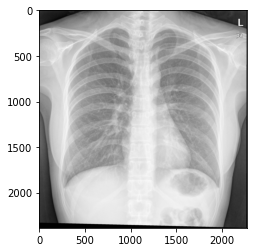

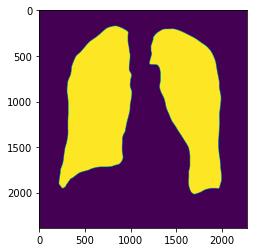

In [10]:
ims(images[1])
ims(masks[1])

In [11]:
preferred_sizes = [96, 128, 160, 192, 224]

IMG_HEIGHT = preferred_sizes[1]
IMG_WIDTH = IMG_HEIGHT

print((IMG_HEIGHT,IMG_WIDTH))

(128, 128)


In [12]:
resized = [flip_resize(images[i], masks[i], input_shape=(IMG_WIDTH, IMG_HEIGHT)) for i in range(len(images))]

In [13]:
X_1 = [img_mask_pair[0] for img_mask_pair in resized]
X_2 = [img_mask_pair[2] for img_mask_pair in resized]

Y_1 = [img_mask_pair[1] for img_mask_pair in resized]
Y_2 = [img_mask_pair[3] for img_mask_pair in resized]

X = X_1 + X_2
Y = Y_1 + Y_2

X = np.array(X)
Y = np.array(Y)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

### Defining the U-Net model:

In [15]:
def channels(x_train):
    return x_train.shape[-1]

IMG_CHANNELS = channels(X_train)
IMG_CHANNELS

3

In [16]:
def unet(input_size=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

### Instantiating the model, compiling it, and training it for a ton of epochs:

#### Instaitiating and compliling it:

In [17]:
unet_example = unet()

In [18]:
unet_example.compile(optimizer='adam',
                     loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                     metrics=['accuracy'])

#### Printing-out images from the test/validation data, defining a function that outputs predicted masks from input model, logit-thresholds, and input image, and defining the intersection-over-union metric that assesses mask-accuracy:

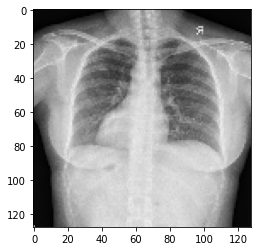

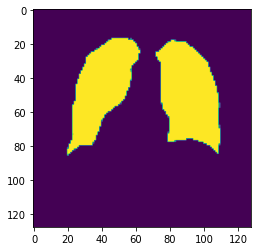

In [19]:
ims(X_test[2])
ims(Y_test[2])

In [20]:
mask_imgs = []

iou_train = []
iou_test = []

In [21]:
i_print = 0

In [22]:
def to_img_gen(lung_xray, desired_model=unet_example, lung_threshold=1/2):
    pred_lung = (1+np.sign(desired_model.predict(lung_xray[tf.newaxis, ...]).squeeze()-(1-lung_threshold)))/2
    pred_lung = np.resize(pred_lung, (pred_lung.shape[0], pred_lung.shape[1], 1))
    return pred_lung

In [23]:
def iou_img(img, mask):
    intersection = np.logical_and(img, mask)
    union = np.logical_or(img, mask)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [24]:
def iou_model(model_Z, XX, YY):
    iou_table = [iou_img(to_img_gen(XX[i], desired_model=model_Z), YY[i]) for i in range(len(XX))]
    return iou_table

#### Running for the first 20 epochs:

Epoch 1/4
7/7 [==============================] - 47s 6s/step - loss: 0.6266 - accuracy: 0.7349
Epoch 2/4
7/7 [==============================] - 40s 6s/step - loss: 0.5590 - accuracy: 0.7435
Epoch 3/4
7/7 [==============================] - 47s 7s/step - loss: 0.5469 - accuracy: 0.7378
Epoch 4/4
7/7 [==============================] - 35s 5s/step - loss: 0.8806 - accuracy: 0.7480


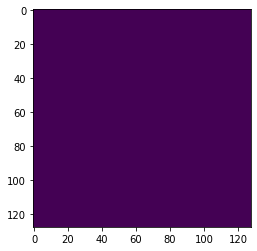

1
1


In [25]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 38s 5s/step - loss: 0.5435 - accuracy: 0.7438
Epoch 2/4
7/7 [==============================] - 43s 6s/step - loss: 0.4874 - accuracy: 0.7438
Epoch 3/4
7/7 [==============================] - 39s 5s/step - loss: 0.4195 - accuracy: 0.7438
Epoch 4/4
7/7 [==============================] - 43s 6s/step - loss: 0.4917 - accuracy: 0.7452


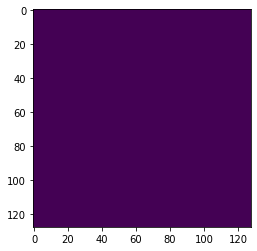

2
2


In [26]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 40s 6s/step - loss: 0.4035 - accuracy: 0.7438
Epoch 2/4
7/7 [==============================] - 42s 6s/step - loss: 0.3763 - accuracy: 0.7438
Epoch 3/4
7/7 [==============================] - 41s 6s/step - loss: 0.3856 - accuracy: 0.7438
Epoch 4/4
7/7 [==============================] - 39s 6s/step - loss: 0.3381 - accuracy: 0.7849


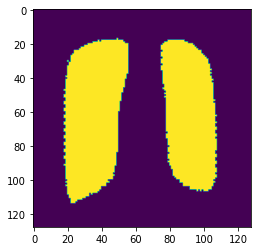

3
3


In [27]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 50s 7s/step - loss: 0.2790 - accuracy: 0.8832
Epoch 2/4
7/7 [==============================] - 51s 7s/step - loss: 0.2371 - accuracy: 0.8997
Epoch 3/4
7/7 [==============================] - 49s 7s/step - loss: 0.2069 - accuracy: 0.9125
Epoch 4/4
7/7 [==============================] - 47s 7s/step - loss: 0.1710 - accuracy: 0.9273


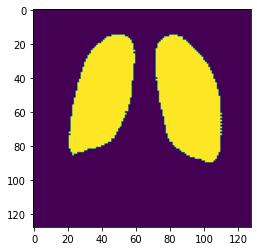

4
4


In [28]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 48s 7s/step - loss: 0.1479 - accuracy: 0.9378
Epoch 2/4
7/7 [==============================] - 46s 7s/step - loss: 0.1426 - accuracy: 0.9395
Epoch 3/4
7/7 [==============================] - 46s 7s/step - loss: 0.1296 - accuracy: 0.9449
Epoch 4/4
7/7 [==============================] - 49s 7s/step - loss: 0.1135 - accuracy: 0.9527


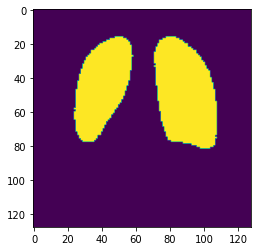

5
5


In [29]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

#### Running from the 21st epoch to the 40th epoch:

Epoch 1/4
7/7 [==============================] - 41s 6s/step - loss: 0.1076 - accuracy: 0.9543
Epoch 2/4
7/7 [==============================] - 41s 6s/step - loss: 0.0996 - accuracy: 0.9588
Epoch 3/4
7/7 [==============================] - 48s 7s/step - loss: 0.0924 - accuracy: 0.9619
Epoch 4/4
7/7 [==============================] - 39s 6s/step - loss: 0.0878 - accuracy: 0.9637


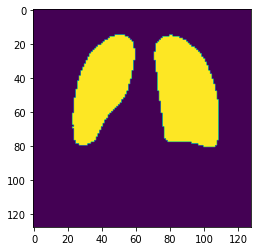

6
6


In [30]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 37s 5s/step - loss: 0.0828 - accuracy: 0.9658
Epoch 2/4
7/7 [==============================] - 37s 5s/step - loss: 0.0771 - accuracy: 0.9679
Epoch 3/4
7/7 [==============================] - 38s 6s/step - loss: 0.0757 - accuracy: 0.9686
Epoch 4/4
7/7 [==============================] - 37s 5s/step - loss: 0.0708 - accuracy: 0.9707


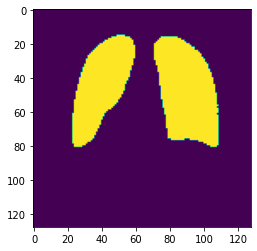

7
7


In [31]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 38s 5s/step - loss: 0.0685 - accuracy: 0.9713
Epoch 2/4
7/7 [==============================] - 38s 5s/step - loss: 0.0664 - accuracy: 0.9720
Epoch 3/4
7/7 [==============================] - 38s 5s/step - loss: 0.0725 - accuracy: 0.9696
Epoch 4/4
7/7 [==============================] - 37s 5s/step - loss: 0.0733 - accuracy: 0.9689


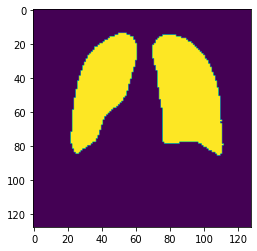

8
8


In [32]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 38s 5s/step - loss: 0.0668 - accuracy: 0.9718
Epoch 2/4
7/7 [==============================] - 37s 5s/step - loss: 0.0616 - accuracy: 0.9739
Epoch 3/4
7/7 [==============================] - 38s 5s/step - loss: 0.0610 - accuracy: 0.9741
Epoch 4/4
7/7 [==============================] - 37s 5s/step - loss: 0.0574 - accuracy: 0.9754


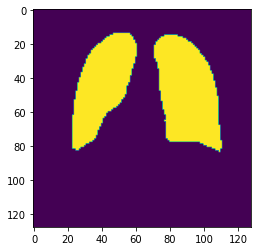

9
9


In [33]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 37s 5s/step - loss: 0.0541 - accuracy: 0.9766
Epoch 2/4
7/7 [==============================] - 38s 5s/step - loss: 0.0527 - accuracy: 0.9773
Epoch 3/4
7/7 [==============================] - 38s 5s/step - loss: 0.0534 - accuracy: 0.9768
Epoch 4/4
7/7 [==============================] - 796s 132s/step - loss: 0.0503 - accuracy: 0.9783


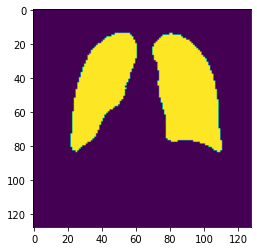

10
10


In [34]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

#### Running from the 41st epoch to the 60th epoch:

Epoch 1/4
7/7 [==============================] - 47s 7s/step - loss: 0.0480 - accuracy: 0.9791
Epoch 2/4
7/7 [==============================] - 61s 9s/step - loss: 0.0530 - accuracy: 0.9772
Epoch 3/4
7/7 [==============================] - 50s 7s/step - loss: 0.0506 - accuracy: 0.9783
Epoch 4/4
7/7 [==============================] - 48s 7s/step - loss: 0.0488 - accuracy: 0.9790


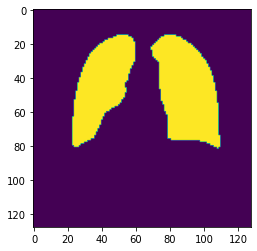

11
11


In [35]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 45s 6s/step - loss: 0.0468 - accuracy: 0.9798
Epoch 2/4
7/7 [==============================] - 45s 6s/step - loss: 0.0453 - accuracy: 0.9804
Epoch 3/4
7/7 [==============================] - 46s 7s/step - loss: 0.0446 - accuracy: 0.9805
Epoch 4/4
7/7 [==============================] - 50s 7s/step - loss: 0.0425 - accuracy: 0.9814


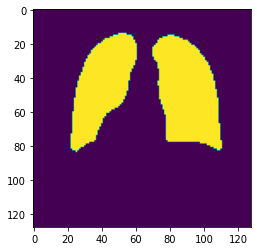

12
12


In [36]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 38s 5s/step - loss: 0.0413 - accuracy: 0.9820
Epoch 2/4
7/7 [==============================] - 37s 5s/step - loss: 0.0402 - accuracy: 0.9825
Epoch 3/4
7/7 [==============================] - 37s 5s/step - loss: 0.0401 - accuracy: 0.9824
Epoch 4/4
7/7 [==============================] - 44s 6s/step - loss: 0.0385 - accuracy: 0.9831


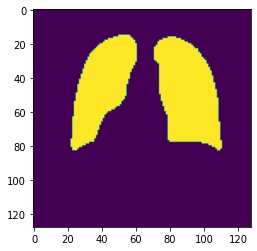

13
13


In [37]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 43s 6s/step - loss: 0.0367 - accuracy: 0.9839
Epoch 2/4
7/7 [==============================] - 43s 6s/step - loss: 0.0356 - accuracy: 0.9843
Epoch 3/4
7/7 [==============================] - 41s 6s/step - loss: 0.0362 - accuracy: 0.9840
Epoch 4/4
7/7 [==============================] - 55s 8s/step - loss: 0.0364 - accuracy: 0.9839


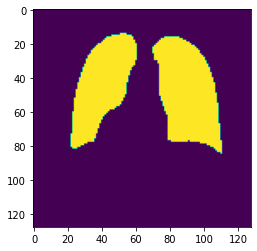

14
14


In [38]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 45s 6s/step - loss: 0.0340 - accuracy: 0.9850
Epoch 2/4
7/7 [==============================] - 43s 6s/step - loss: 0.0338 - accuracy: 0.9850
Epoch 3/4
7/7 [==============================] - 39s 6s/step - loss: 0.0322 - accuracy: 0.9858
Epoch 4/4
7/7 [==============================] - 50s 7s/step - loss: 0.0313 - accuracy: 0.9861


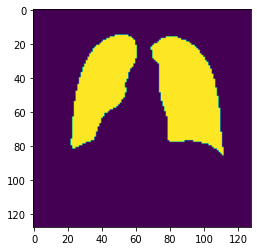

15
15


In [39]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

#### Running from the 61st to the 80th epoch:

Epoch 1/4
7/7 [==============================] - 46s 7s/step - loss: 0.0313 - accuracy: 0.9860
Epoch 2/4
7/7 [==============================] - 46s 6s/step - loss: 0.0300 - accuracy: 0.9866
Epoch 3/4
7/7 [==============================] - 41s 6s/step - loss: 0.0300 - accuracy: 0.9865
Epoch 4/4
7/7 [==============================] - 39s 6s/step - loss: 0.0296 - accuracy: 0.9866


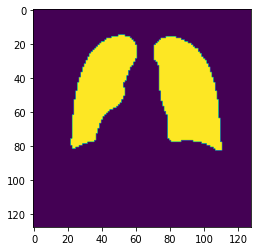

16
16


In [40]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 40s 6s/step - loss: 0.0297 - accuracy: 0.9866
Epoch 2/4
7/7 [==============================] - 44s 6s/step - loss: 0.0293 - accuracy: 0.9867
Epoch 3/4
7/7 [==============================] - 35s 5s/step - loss: 0.0274 - accuracy: 0.9877
Epoch 4/4
7/7 [==============================] - 37s 5s/step - loss: 0.0268 - accuracy: 0.9879


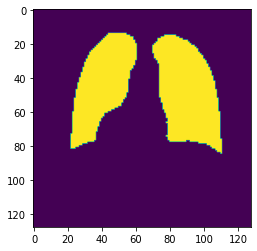

17
17


In [41]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 37s 5s/step - loss: 0.0260 - accuracy: 0.9882
Epoch 2/4
7/7 [==============================] - 38s 5s/step - loss: 0.0256 - accuracy: 0.9884
Epoch 3/4
7/7 [==============================] - 34s 5s/step - loss: 0.0255 - accuracy: 0.9884
Epoch 4/4
7/7 [==============================] - 34s 5s/step - loss: 0.0248 - accuracy: 0.9886


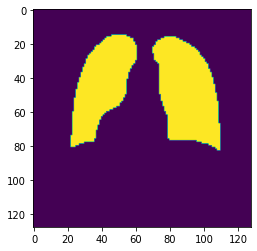

18
18


In [42]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 34s 5s/step - loss: 0.0265 - accuracy: 0.9879
Epoch 2/4
7/7 [==============================] - 34s 5s/step - loss: 0.0246 - accuracy: 0.9888
Epoch 3/4
7/7 [==============================] - 38s 6s/step - loss: 0.0235 - accuracy: 0.9893
Epoch 4/4
7/7 [==============================] - 35s 5s/step - loss: 0.0233 - accuracy: 0.9893


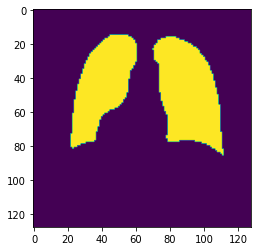

19
19


In [43]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

Epoch 1/4
7/7 [==============================] - 36s 5s/step - loss: 0.0215 - accuracy: 0.9901
Epoch 2/4
7/7 [==============================] - 38s 5s/step - loss: 0.0206 - accuracy: 0.9905
Epoch 3/4
7/7 [==============================] - 34s 5s/step - loss: 0.0241 - accuracy: 0.9890
Epoch 4/4
7/7 [==============================] - 35s 5s/step - loss: 0.0241 - accuracy: 0.9890


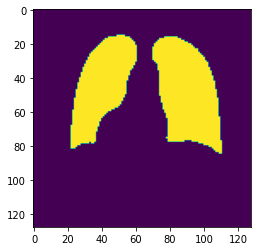

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [52]:
i_print = i_print+1
TRAIN_LENGTH = len(X_train)
EPOCHS = 4
VAL_SUBSPLITS = 5
BATCH_SIZE = 20
VALIDATION_STEPS = len(X_test)//BATCH_SIZE//VAL_SUBSPLITS
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
model_history = unet_example.fit(X_train,Y_train ,epochs=EPOCHS,
                                 steps_per_epoch=STEPS_PER_EPOCH,
                                 validation_steps = VALIDATION_STEPS,
                                 validation_data=(X_test, Y_test))
mask_imgs.append(to_img_gen(X_test[2],desired_model=unet_example))
ims(mask_imgs[-1])
iou_train.append(iou_model(unet_example, X_train, Y_train))
iou_test.append(iou_model(unet_example, X_test, Y_test))
print(i_print)
print(len(mask_imgs))

### Playing with metrics for fitting quality/overfitting, and making a movie of the images for the masks generated by this generic U-Net model after [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80]-epochs of training on this data:

In [54]:
list(iou_train).append(iou_model(unet_example, X_train, Y_train))
list(iou_test).append(iou_model(unet_example, X_test, Y_test))

In [61]:
print(len(iou_train))
print(len(iou_test))
print(len(mask_imgs))

19
19
20


In [156]:
img_movie = []
img_movie.append(X_test[2])
img_movie.append(Y_test[2])
img_movie.append(Y_test[2]*X_test[2])

for i in range(len(mask_imgs)):
    img_movie.append(mask_imgs[i])

# img_movie.append(Y_test[2])
img_movie.append(mask_imgs[-1]*X_test[2])

In [58]:
iou_test = np.array(iou_test)
iou_train = np.array(iou_train)

In [59]:
iou_tst_means = [iou_test[i].mean() for i in range(len(iou_test))]
iou_trn_means = [iou_train[i].mean() for i in range(len(iou_train))]

In [ ]:
# tst_means = [0.0, 0.0, 0.6489694728149928, 0.7266588789321151, 0.8052370430077167, 0.8442360113728337, 0.8742414602027924, 0.8727583980319354, 0.8776694849177968, 0.8840375246566569, 0.889544083043597, 0.892669096834696, 0.8863306264489823, 0.894084436415667, 0.8978214563627097, 0.8967700951716299, 0.8954264938637954, 0.8979462568337697, 0.8940052135539364]
# trn_means = [0.0, 0.0, 0.6672795317356706, 0.7357771264575715, 0.8087537462073473, 0.8466899470783937, 0.882734063792784, 0.881950126037329, 0.8901494445381902, 0.896244313411281, 0.907011362799542, 0.9115003358570348, 0.9096065378961278, 0.9178582809203897, 0.9184488548683778, 0.9211386632372436, 0.9287161328958129, 0.9267052953162379, 0.9382534616729141]

In [62]:
iou_tst_x, iou_tst_y = [i for i in range(len(iou_tst_means))], iou_tst_means
iou_trn_x, iou_trn_y = [i for i in range(len(iou_trn_means))], iou_trn_means
base_x, base_y = [i for i in range(len(iou_trn_means))], [1 for i in range(len(iou_trn_means))]

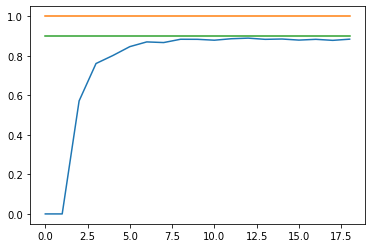

In [85]:
# plt.plot(iou_trn_x, iou_trn_y, label="IoU for train")
plt.plot(iou_tst_x, iou_tst_y, label="IoU for test")
plt.plot(base_x, base_y, label="perfect IoU-line")
plt.plot(base_x, np.array(base_y)*0.9, label="90% IoU-line")
plt.show()

In [69]:
iou_tst_min = [iou_test[i].min() for i in range(len(iou_test))]
iou_trn_min = [iou_train[i].min() for i in range(len(iou_train))]

In [70]:
# tst_min = [0.0, 0.0, 0.47275204359673023, 0.530416951469583, 0.5808034345292855, 0.5979505726341169, 0.6724137931034483, 0.689205579138872, 0.6638036809815951, 0.65958756540474, 0.6838729383017715, 0.6913467397928093, 0.7072044334975369, 0.7055572612833896, 0.7272447724477245, 0.7202840382834208, 0.6435143959631938, 0.6762899262899262, 0.634742594190394]
# trn_min = [0.0, 0.0, 0.3801227479706989, 0.37665369649805447, 0.3604966139954853, 0.3983721456025322, 0.5284000905182168, 0.5754354218502601, 0.6187358916478556, 0.6470455570590888, 0.7158119658119658, 0.7240960194469767, 0.7778452200303491, 0.7893934775982933, 0.727068345323741, 0.794435857805255, 0.8278348263054403, 0.7756923076923077, 0.8968716861081655]

In [71]:
iou_tst_max = [iou_test[i].max() for i in range(len(iou_test))]
iou_trn_max = [iou_train[i].max() for i in range(len(iou_train))]

In [72]:
# tst_max = [0.0, 0.0, 0.7541809851088201, 0.8458096013018714, 0.8995037220843672, 0.9244011976047904, 0.9382280809319435, 0.9385738178500836, 0.93624212628668, 0.9437716262975778, 0.9471431628504173, 0.9494612232508727, 0.9447561501942167, 0.9532871972318339, 0.9475683890577508, 0.9509122502172024, 0.9528277960943444, 0.9540714444197914, 0.9562484284636661]
# trn_max = [0.0, 0.0, 0.8198395331874544, 0.8540127388535032, 0.8991250643335049, 0.9279846180737633, 0.9355729406350667, 0.9404417364813404, 0.944905054827494, 0.9465039887376818, 0.9486123156981786, 0.9525709219858156, 0.9544172932330827, 0.9589167564240653, 0.9599812777907794, 0.9590271691498685, 0.9553571428571429, 0.9607657764121957, 0.9585225552528005]

In [73]:
iou_tst_dev = [iou_test[i].std() for i in range(len(iou_test))]
iou_trn_dev = [iou_train[i].std() for i in range(len(iou_train))]

In [74]:
# tst_dev = [0.0, 0.0, 0.06783418059651877, 0.06915613628671392, 0.07159487789518193, 0.06955974830345017, 0.05567501528943339, 0.057243662335118684, 0.05819914251241823, 0.058897584490806565, 0.0561571924655277, 0.054043580214042666, 0.053979962698783905, 0.05182969582852427, 0.05113257807151888, 0.05325653983025259, 0.060533519901920366, 0.05726256244950077, 0.06053237625992484]
# trn_dev = [0.0, 0.0, 0.07792728682947286, 0.08140970006366537, 0.07828406717124407, 0.07539522926913245, 0.058638247416813595, 0.05358196295025043, 0.0524114464319737, 0.05086354338035628, 0.04055628228058348, 0.040325461551757036, 0.03204195674963373, 0.03167816461465432, 0.03639800165399277, 0.029430725695310033, 0.019300253716510358, 0.028001323280471762, 0.012944788936747277]

### Making a mooovie

#### Making the images:

In [83]:
from PIL import Image
import numpy as np

def img_png(img, name):
    data = img
    
    if data.shape[-1]==1:
        ones = np.ones((data.shape[0], data.shape[1], 3))
        data = data * ones
    
    #Rescale to 0-255 and convert to uint8
    rescaled = (255.0 / data.max() * (data - data.min())).astype(np.uint8)

    if len(name) < 2:
        name = "0"+name
    
    im = Image.fromarray(rescaled)
    im.save(f'/Users/dmcgady/code/dmcgady196884/xrayproject/notebooks/XY_images/{name}.png')

    return f"Made a png with name {name}.png"

In [157]:
def make_pngs_for_movie():
    [ img_png(img_movie[i],f"{i}") for i in range(len(img_movie))]
    pass

make_pngs_for_movie()

#### Messing around with different python libraries to try and turn sets of images into movies:

In [114]:
# A nice function to always return integer values within a range:
def nice_movee(frame):
    frame_range = len(img_movie)
    frame = int(np.round(frame))
    if frame < 0:
        return frame + frame_range
    elif frame > frame_range:
        return frame - frame_range
    else:
        return frame

nice_movee(-1)

23

In [151]:
from moviepy.editor import *

img = img_movie[:]

clips = [ImageClip(m).set_duration(1) for m in img]

concat_clip = concatenate_videoclips(clips, method="compose")
concat_clip.write_videofile("clam.mp4", fps=24)

t:  18%|█▊        | 104/576 [00:00<00:00, 1031.80it/s, now=None]

Moviepy - Building video clam.mp4.
Moviepy - Writing video clam.mp4




t: 100%|██████████| 48/48 [8:14:19<00:00,  8.80it/s, now=None]  

Moviepy - Done !
Moviepy - video ready clam.mp4


t:   0%|          | 0/24 [00:00<?, ?it/s, now=None]

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4




t: 100%|██████████| 48/48 [6:49:55<00:00,  8.80it/s, now=None]A

Moviepy - Done !
Moviepy - video ready __temp__.mp4


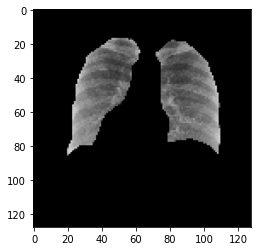

In [150]:
# importing matplot lib
import matplotlib.pyplot as plt
import numpy as np

# importing movie py libraries
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

# numpy array
x = np.linspace(-2, 2, 200)

# duration of the video
duration = 24

# matplot subplot
fig, ax = plt.subplots()

# method to get frames
def make_frame(t):    
    # clear
    ax.clear()    
#     ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * t-5 * np.pi / duration * t), lw = 5)
    ax.imshow(img_movie[nice_movee(t)])
#     ax.set_ylim(-1.5, 2.5)    
    # returning mumpy image
    return mplfig_to_npimage(fig)

# creating animation
animation = VideoClip(make_frame, duration = duration)

# displaying animation with auto play and looping
animation.ipython_display(fps = 1, loop = False, autoplay = True)
# animation.write_videofile("gfg_intro.mp4", fps=2, duration=10)
# animation.write_videofile("gfg_intro.mp4", fps=2)

# Source: <https://www.geeksforgeeks.org/moviepy-creating-animation-using-matplotlib/>

In [141]:
from moviepy.video.io.VideoFileClip import VideoFileClip
from moviepy.Clip import Clip 


# animation = VideoFileClip.write_videofile("my_video_file.mp4")

In [149]:
# import os
# from moviepy.editor import *

# base_dir = os.path.realpath(".")
# print(base_dir)
# directory=sorted(os.listdir('.'))
# print(directory)

# for filename in directory:
#   if filename.endswith(".png"):
#     clips.append(ImageClip(filename).set_duration(1))

# print(clips)
# video = concatenate(clips, method="compose")
# video.write_videofile('test1.mp4', fps=24)

# from moviepy.editor import *

# img = img_movie[:]

# clips = [ImageClip(m).set_duration(1) for m in img]

# concat_clip = concatenate_videoclips(clips, method="compose")
# concat_clip.write_videofile("test.mp4", fps=24)